In [1]:
import tensorflow as tf
import time
tf.__version__
from tensorflow.keras import layers, models
import os
import cv2
import numpy as np
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import shutil
#import tensorflow_datasets as tfds
from IPython import display
print("GPU Available: ", tf.test.is_gpu_available())


GPU Available:  False


In [2]:
BATCH_SIZE = 500
BUFFER_SIZE =  60000




# path to data directory

data_dir = "img_align_celeba"

# image size that we want

img_size = 28


In [3]:
def training_data():
    
    train_data = []
    for img in tqdm(os.listdir(data_dir)):
        path = os.path.join(data_dir,img)
        
        try:
            
            img = cv2.resize(cv2.imread(path),(img_size, img_size))
            normalizedImg = np.zeros((28, 28))
            normalizedImg = cv2.normalize(img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
            RGB_img = cv2.cvtColor(normalizedImg, cv2.COLOR_BGR2RGB)
            train_data.append([np.array(RGB_img)])

        except:
                    print('skipping...')
        
                     
    shuffle(train_data)
    shutil.rmtree('train_data.npy', ignore_errors = True)
    np.save('train_data.npy', train_data)
   # return train_data
    

In [5]:
training_data()

100%|██████████| 202599/202599 [03:29<00:00, 965.82it/s] 


In [3]:
#loading data from file

dt = np.load('train_data.npy', 'r+', allow_pickle= True)
data = dt.squeeze()

print(data.shape)
#data.astype(np.float64)
print(type(data[0]))
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


(202599, 28, 28, 3)
<class 'numpy.ndarray'>


(28, 28, 3)


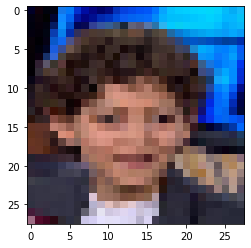

In [4]:
#np.random.shuffle(data)
plt.imshow(data[0])
print(data[0].shape)
plt.show()

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid', use_bias=False))
    assert model.output_shape == (None, 7, 7, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 3)

    return model

(1, 28, 28, 3)


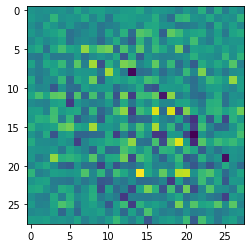

In [6]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])


In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))    
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[-0.0009139]], shape=(1, 1), dtype=float32)


In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


#discntr loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#gen loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [10]:
#optimizers

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [11]:
# checkpoints for resuming

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [12]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [13]:
# `tf.function` is used for autograph
@tf.function
def train_step(images):
    
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                 generated_images = generator(noise, training=True)
                 real_output = discriminator(images, training=True)
            
                 fake_output = discriminator(generated_images, training=True)
                 gen_loss = generator_loss(fake_output)
                 disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [14]:
def train(train_dataset, epochs):
          for epoch in range(epochs):
                    start = time.time()

                    for image_batch in train_dataset:
                        image_batch = tf.cast(image_batch, tf.float32)
                        train_step(image_batch)

                    # Produce images for the GIF as we go
                        display.clear_output(wait=True)
                        generate_and_save_images(generator,epoch + 1,seed)

                    # Save the model every 1 epochs
                        if (epoch + 1) % 2 == 0:
                             checkpoint.save(file_prefix = checkpoint_prefix)

                    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            # Generate after the final epoch
          display.clear_output(wait=True)
          generate_and_save_images(generator, epochs,seed)


In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


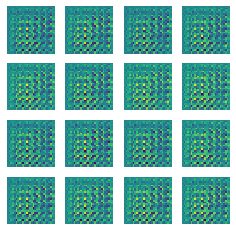

In [ ]:
%%time
print(tf.compat.v1.logging)
train(train_dataset, EPOCHS)
# I have not trained this model fully because i am using cpu power

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


In [ ]:
display_image(EPOCHS)
